# Word Decoding
This notebook is meant to make it easy to incorporate a new model and decode word information from our podcast data. All you must do to support a new model is:

1. Change how data is preprocess using the preprocess_neural_data.
2. Setup configuration for your own mode.
3. Define a new model and get_model() function.

More details are provided below on how to do this but it should but this should give close to a functional training pipeline although you may of course need to customize it more for your own use case. The only task implemented here currently is word decoding by predicting word embeddings from neural data. If you run into any issues feel free to reach out to me zparis99@gmail.com. Before running the code you should download the data and have a setup virtual or conda environment to get access to dependencies. You can do that by running `./setup.sh`. Use `./setup.sh --help` for an overview of the options particularly if you want GPU dependencies.

I've also included various tests in tests/ which could be useful for maintaining the code and also to inspire confidence that the implementation is correct.

In [1]:
# Imports
import os
from typing import Optional

import h5py
import mne
from mne_bids import BIDSPath
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import metrics
from decoding_utils import should_update_best, should_update_gradient_accumulation, compute_word_embedding_task_metrics
from fold_utils import get_sequential_folds, get_zero_shot_folds
from plot_utils import plot_training_history, plot_cv_results

/tmp/ipykernel_3676101/3864492491.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Configuration

In [2]:
# Dictionary to map names to metrics. Can configure to use these how you would like. See below training configuration. If you want to configure more metrics, make sure to add them here.
simple_metric_dict = {
    "mse": metrics.mse_metric,
    "nll_embedding": metrics.compute_nll_contextual,
    "cosine_sim": metrics.cosine_similarity,
    "cosine_distance": metrics.cosine_distance,
    "similarity_entropy": metrics.similarity_entropy,
}

This configuration should give you a lot of power over the way your model is finetuned. Pay particular attention to the lag (where to center neural data relative to word onset), window_width (which defines how wide of a window over neural data we use), model_params (will need to change this to fit your model configuration), and the other metric_configurations as is useful for your training. Your performance will  vary widely based on the lag you choose and you can see in figure 8 of this paper: https://www.nature.com/articles/s41593-022-01026-4#Sec5 roughly what this will look like.

If you want to train over multiple subjects the electrode_file_path could be useful with the included all_subject_sig.csv. Otherwise you can specify subjects and electrodes using the subject_ids and channel_reg_ex fields.

In [3]:
# Data configuration
# Time relative to word onset to center neural data around. In ms.
lag: int = 0
# The width of neural data to gather around each word onset in seconds.
window_width: float = 0.5
# The name of the embeddings to use. Currently supports gpt-2xl and arbitrary.
embedding_type: str = "gpt-2xl"
# Layer of model to gather embeddings from. Required if using gpt2-xl.
embedding_layer: Optional[int] = 24
# Root of data folder.
data_root: str = "data"
# Number of embeddings to reduce the embeddings to using pca. If None, don't run PCA.
embedding_pca_dim: Optional[int] = 50
# CSV file with columns subject (subject integer id) and elec (string name of electrode).
# If not set then defaults to configured subject_ids and channel_reg_ex. See our significant electrode file.
electrode_file_path: Optional[str] = "all_subject_sig.csv"
# The subject id's to include in your analysis. For the podcast data they must all be in the range [1, 9]
subject_ids: list[int] = [9]
# A regular expression to pick which channels you are interested in.
# (i.e. "LG[AB]*" will select channels that start with "LGA" or "LGB")
channel_reg_ex: Optional[str] = "^G([1-9]|[1-5][0-9]|6[0-4])$" # G1 - G64
# Column name in dataframe to use for grouping by words.
word_column: Optional[str] = "lemmatized_word"
# Used in preprocessor specific to the PITOM model. See preprocess_neural_data() below for overwriting with your own.
num_average_samples: int = 32 

# Training Configuration
# The batch size to train our decoder with.
batch_size: int = 32
# The maximum number of epochs to train over each fold with.
epochs: int = 100
# The learning rate to use when training. TODO: currently staic lr, could use a scheduler in the future.
learning_rate: float = 0.001
# The amount of weight decay to use as regularization in our optimizer.
weight_decay: float = 0.0001
# If cosine similarity between our predicted embeddings and the actual embeddings do not improve after this many steps
# stop training for this fold early.
early_stopping_patience: int = 10
# Number of folds to train over per-lag.
n_folds: int = 5
# Path to write model checkpoints to.
model_dir: str = "models"
# Type of fold generation to use. One of "sequential_folds" or "zero_shot_folds". Sequential folds mean we
# use time segmented folds. zero_shot_folds requires that no word in the test set appears in the training set.
fold_type: str = "sequential_folds"
# Losses to use, by default use nll_embedding. Must be defined in simple_metric_dict. We find that nll_embedding
# tends to be the best for our decoding tests because it is a contrastive loss (roughly equivalent to negative log likelihood over a batch)
losses: list[str] = ["nll_embedding"]
# Weight to assign to each loss. Should be parallel array with losses.
loss_weights: list[float] = [1.0]
# Metrics to track during training. Must be defined in simple_metric_dict.
metric_name_conf: list[str] = ["mse", "cosine_sim"]
# Metric to use for early stopping over validation set. Must be either the loss or in metrics.
early_stopping_metric: str = "cosine_sim"
# Whether or not a smaller value is better for early_stopping_metric. Should be False for metrics you
# want to increase (i.e. cosine similarity) but True for ones you want to decrease (i.e. MSE).
smaller_is_better: bool = False
# Number of gradient accumulation steps.
grad_accumulation_steps: int = 1
# Minimum number of occurences of a word in training set to be used for ROC-AUC calculation.
min_train_freq_auc: int = 5
# Minimum number of occurences of a word in test set to be used for ROC-AUC calculation.
min_test_freq_auc: int = 3
# Sets the k we use in top-k metrics.
top_k_thresholds: list[int] = [1, 5, 10]
# Whether or not to display plots during training.
plot_results=True

# Model configuration (specific to your model). Passed in the get_model function below.
model_params = {
  "conv_filters": 128,
  "reg": 0.35,
  "reg_head": 0,
  "dropout": 0.2,
  "num_models": 10,
  "output_dim": 50,
}
# Optional parameters to send through the forward pass of your model when doing embedding evaluation.
evaluation_model_params = {"preserve_ensemble": True}

# Other configuration
# Base directory to output results to.
output_dir: str = "results"
# Base directory to write models to.
model_dir: str = "models"

## Model Setup

You can replace this with your own DIVER model code here, or just import from your own files. The only thing that matters is that the output of the model is a predicted word embedding or ensemble of embeddings.

This model is roughly the one used for decoding in the 2022 paper: https://www.nature.com/articles/s41593-022-01026-4#Sec31. If you have your model setup to return a predicted word embedding, the EmbeddingPrediction class below may be useful for translating that into a prediction over all of the words as specified in the Decoding analysis section in the paper above.

In [4]:
class PitomModel(nn.Module):
    def __init__(
        self,
        input_channels,
        output_dim,
        conv_filters=128,
        reg=0.35,
        reg_head=0,
        dropout=0.2
    ):
        """
        PyTorch implementation of the PITOM decoding model.
        
        Args:
            input_channels: Numbr of electrodes in data (int)
            output_dim: Dimension of output vector (int)
            conv_filters: Number of convolutional filters (default: 128)
            reg: L2 regularization factor for convolutional layers (default: 0.35)
            reg_head: L2 regularization factor for dense head (default: 0)
            dropout: Dropout rate (default: 0.2)
        """
        super(PitomModel, self).__init__()
        
        self.conv_filters = conv_filters
        self.reg = reg
        self.reg_head = reg_head
        self.dropout = dropout
        self.output_dim = output_dim
        
        # Define the CNN architecture
        self.desc = [(conv_filters, 3), ('max', 2), (conv_filters, 2)]
        
        # Build the layers
        self.layers = nn.ModuleList()
        
        for i, (filters, kernel_size) in enumerate(self.desc):
            if filters == 'max':
                self.layers.append(
                    nn.MaxPool1d(kernel_size=kernel_size, stride=kernel_size, padding=kernel_size//2)
                )
            else:
                # Conv block
                conv = nn.Conv1d(
                    in_channels=input_channels if i == 0 else conv_filters,
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=0,  # 'valid' in Keras
                    bias=False
                )
                
                # Apply weight decay equivalent to L2 regularization
                self.layers.append(conv)
                self.layers.append(nn.ReLU())
                self.layers.append(nn.BatchNorm1d(filters))
                self.layers.append(nn.Dropout(dropout))
                
                input_channels = filters
        
        # Final locally connected layer (using Conv1d with groups as approximation).
        # Not exactly the same as original paper but pytorch does not have locally connected layers.
        self.final_conv = nn.Conv1d(
            in_channels=conv_filters,
            out_channels=conv_filters,
            kernel_size=2,
            stride=1,
            padding=0,  # 'valid' in Keras
            bias=True
        )
        
        self.final_bn = nn.BatchNorm1d(conv_filters)
        self.final_act = nn.ReLU()
        
        # Output layer
        self.dense = nn.Linear(conv_filters, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        x = self.final_conv(x)
        x = self.final_bn(x)
        x = self.final_act(x)
        
        x = F.adaptive_max_pool1d(x, 1).squeeze(-1)
        
        x = self.dense(x)
        x = self.layer_norm(x)
        x = self.tanh(x)
            
        return x


class EnsemblePitomModel(nn.Module):
    def __init__(
        self,
        num_models: int,
        input_channels,
        output_dim: int,
        conv_filters=128,
        reg=0.35,
        reg_head=0,
        dropout=0.2
    ):
        """
        PyTorch implementation of the PITOM decoding model.
        
        Args:
            num_models: The number of models to include in the ensemble. The outputs will be averaged at the end.
            input_channels: Numbr of electrodes in data (int)
            output_dim: Dimensionality of output (int)
            conv_filters: Number of convolutional filters (default: 128)
            reg: L2 regularization factor for convolutional layers (default: 0.35)
            reg_head: L2 regularization factor for dense head (default: 0)
            dropout: Dropout rate (default: 0.2)
        """
        super(EnsemblePitomModel, self).__init__()

        self.models = nn.ModuleList()
        for _ in range(num_models):
            self.models.append(PitomModel(
                input_channels,
                output_dim,
                conv_filters=conv_filters,
                reg=reg,
                reg_head=reg_head,
                dropout=dropout
            ))

    def forward(self, x, preserve_ensemble=False):
        # Run all models and average together all embeddings.
        embeddings = torch.stack([model(x) for model in self.models], dim=1)
        if not preserve_ensemble:
            embeddings = embeddings.mean(1)
        return embeddings


# Make sure to update this get_model function here which takes in your configured model parameters above.
def get_model():
    return EnsemblePitomModel(**model_params)

## Data Setup

Make sure you've run ./setup.sh to download the dataset to your machine. If you want it to create a venv with gpu dependencies you can run ./setup.sh --gpu. You can overwrite this preprocess_neural_data to pass whatever data you want to your model. You can see in the code below how this is called and that this defines the input to your data.

In [5]:
# Overwrite this to preprocess the data as needed for your model. Will be passed straight into your decoding model in this form.
# see below for where it is called.
def preprocess_neural_data(data):
    return data.reshape(
        data.shape[0], data.shape[1], -1, num_average_samples
    ).mean(-1)

### Utils

In [6]:
def get_gpt_2xl_embeddings(df_contextual):
    """
    Loads GPT-2 XL contextual embeddings and aligns them to word-level units.

    This function:
    1. Loads sub-token-level GPT-2 XL embeddings from a specified HDF5 file.
    2. Groups the embeddings according to word indices provided in the contextual DataFrame.
    3. Averages sub-token embeddings to produce a single embedding vector per word.

    Args:
        df_contextual (pd.DataFrame): DataFrame containing token-level data, including `word_idx` for grouping.

    Returns:
        np.ndarray: A 2D array of shape (num_words, embedding_dim), where each row is a word-level embedding.
    """
    embedding_path = os.path.join(
        data_root, "stimuli/gpt2-xl/features.hdf5"
    )

    with h5py.File(embedding_path, "r") as f:
        contextual_embeddings = f[f"layer-{embedding_layer}"][...]

    # Group embeddings for each word (some are sub-tokenized).
    aligned_embeddings = []
    for _, group in df_contextual.groupby("word_idx"):  # group by word index
        indices = group.index.to_numpy()
        average_emb = contextual_embeddings[indices].mean(0)  # average features
        aligned_embeddings.append(average_emb)
    aligned_embeddings = np.stack(aligned_embeddings)

    return aligned_embeddings

def get_arbitrary_embeddings(df_word):
    """
    Generates arbitrary (random) embeddings for each unique word in the input DataFrame.

    Parameters:
    -----------
    df_word : pandas.DataFrame
        A DataFrame containing a column named 'word', representing a list of words.
    Returns:
    --------
    pd.DataFrame:
        df_word with arbitrary embeddings in embedding column

    Notes:
    ------
    - Embeddings are randomly sampled from a uniform distribution in the range [-1.0, 1.0]
      with an initial dimensionality of 50, then truncated or padded to match
      `embedding_pca_dim`.
    - Useful as a placeholder or for testing models where real word embeddings are not required.
    """
    words = df_word.word.tolist()
    unique_words = list(set(words))
    word_to_idx = {}
    for i, word in enumerate(words):
        if word not in word_to_idx:
            word_to_idx[word] = []
        word_to_idx[word].append(i)

    arbitrary_embeddings_per_word = np.random.uniform(
        low=-1.0, high=1.0, size=(len(unique_words), embedding_pca_dim)
    )
    arbitrary_embeddings = np.zeros((len(words), embedding_pca_dim))
    for i, word in enumerate(unique_words):
        for idx in word_to_idx[word]:
            arbitrary_embeddings[idx] = arbitrary_embeddings_per_word[i]

    df_word["target"] = list(arbitrary_embeddings)

    return df_word

def word_embedding_decoding_task():
    """
    Loads and processes word-level data and retrieves corresponding embeddings based on specified parameters.

    This function performs the following steps:
    1. Loads a transcript file containing token-level information.
    2. Retrieves aligned embeddings for each token or word, depending on the specified embedding type.
    3. Groups sub-token entries into full words using word indices.
    4. Optionally applies PCA to reduce the dimensionality of the embeddings.

    Returns:
        Tuple[pd.DataFrame, np.ndarray]: A DataFrame containing word-level information (word, start time, end time),
        and a NumPy array of corresponding word-level embeddings under the header target.
    """
    import nltk
    from nltk.stem import WordNetLemmatizer as wl

    try:
        nltk.data.find("corpora/wordnet")
        print("WordNet already downloaded")
    except LookupError:
        print("Downloading WordNet...")
        nltk.download("wordnet")
        nltk.download("wordnet")

    transcript_path = os.path.join(
        data_root, "stimuli/gpt2-xl/transcript.tsv"
    )

    # Load transcript
    df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)

    aligned_embeddings = get_gpt_2xl_embeddings(
        df_contextual
    )

    # Group sub-tokens together into words.
    df_word = df_contextual.groupby("word_idx").agg(
        dict(word="first", start="first", end="last")
    )
    df_word["norm_word"] = df_word.word.str.lower().str.replace(
        r"^[^\w\s]+|[^\w\s]+$", "", regex=True
    )
    df_word["lemmatized_word"] = df_word.norm_word.apply(lambda x: wl().lemmatize(x))

    if embedding_type == "gpt-2xl":
        df_word["target"] = list(aligned_embeddings)
    elif embedding_type == "arbitrary":
        df_word = get_arbitrary_embeddings(df_word)

    if embedding_pca_dim:
        pca = PCA(n_components=embedding_pca_dim, svd_solver="auto")
        df_word.target = list(pca.fit_transform(df_word.target.tolist()))

    return df_word


def get_data(
    lag,
    raws: list[mne.io.Raw],
    df_word: pd.DataFrame,
    window_width: float,
    word_column: Optional[str] = None,
):
    """Gather data for every word in df_word from raw.

    Args:
        lag: the lag relative to each word onset to gather data around
        raws: list of mne.Raw object holding electrode data
        df_word: dataframe containing columns start, end, word, and target
        window_width: the width of the window which is gathered around each word onset + lag
        word_column: If provided, will return the column of words specified here.
    """
    datas = []
    for raw in raws:
        # Calculate time bounds for filtering
        tmin = lag / 1000 - window_width / 2
        tmax = lag / 1000 + window_width / 2 - 2e-3
        data_duration = raw.times[-1]  # End time of the data

        # Filter out events where the time window falls outside data bounds
        valid_mask = (df_word.start + tmin >= 0) & (
            df_word.start + tmax <= data_duration
        )
        df_word_valid = df_word[valid_mask].reset_index(drop=True)

        if len(df_word_valid) == 0:
            # No valid events for this raw, skip
            continue

        events = np.zeros((len(df_word_valid), 3), dtype=int)
        events[:, 0] = (df_word_valid.start * raw.info["sfreq"]).astype(int)

        epochs = mne.Epochs(
            raw,
            events,
            tmin=tmin,
            tmax=tmax,
            baseline=None,
            proj=False,
            event_id=None,
            preload=True,
            on_missing="ignore",
            event_repeated="merge",
            verbose="ERROR",
        )

        data = epochs.get_data(copy=False)
        selected_targets = df_word_valid.target[epochs.selection]

        # TODO: Clean this up so we don't need to pass around this potentially None variable.
        if word_column:
            selected_words = df_word_valid[word_column].to_numpy()[epochs.selection]
        else:
            selected_words = None

        # Make sure the number of samples match
        assert data.shape[0] == selected_targets.shape[0], "Sample counts don't match"
        if selected_words is not None:
            assert data.shape[0] == selected_words.shape[0], "Words don't match"

        datas.append(data)

    if len(datas) == 0:
        raise ValueError("No valid events found within data time bounds")

    datas = np.concatenate(datas, axis=1)
    # Your preprocessor is called here.
    datas = preprocess_neural_data(datas)

    return datas, selected_targets, selected_words

def load_raws(per_subject_electrodes):
    """
    Loads raw iEEG data for multiple subjects based on specified parameters.

    This function:
    1. Iterates over subject IDs provided in the configuration.
    2. Constructs BIDS-compliant file paths to locate preprocessed high-gamma iEEG data.
    3. Loads each subject's data using MNE's `read_raw_fif` function.
    4. Optionally filters channels using a regular expression (e.g., for selecting specific electrode groups).
    5. Collects and returns a list of raw MNE objects.

    Args:
        per_subject_electrodes: dictionary mapping subject ID's to a list of string names for the electrodes to use.

    Returns:
        List[mne.io.Raw]: A list of raw iEEG recordings for the specified subjects.
    """
    raws = []
    for sub_id in subject_ids:
        file_path = BIDSPath(
            root=os.path.join(data_root, "derivatives/ecogprep"),
            subject=f"{sub_id:02}",
            task="podcast",
            datatype="ieeg",
            description="highgamma",
            suffix="ieeg",
            extension=".fif",
        )

        raw = mne.io.read_raw_fif(file_path, verbose=False)
        if per_subject_electrodes:
            subject_electrode_names = per_subject_electrodes[sub_id]
            picks = mne.pick_channels(raw.ch_names, subject_electrode_names)
            raw = raw.pick(picks)
        elif channel_reg_ex:
            picks = mne.pick_channels_regexp(raw.ch_names, channel_reg_ex)
            raw = raw.pick(picks)
        raws.append(raw)

    return raws


def read_electrode_file(file_path: str, subject_mapping: Optional[dict[int, int]]=None):
    """
    Parse an electrode mapping CSV file to create a subject-to-electrodes mapping.

    This function reads a CSV file containing electrode information organized by subject
    and returns a dictionary mapping each subject ID to their list of electrode names.
    Each subject can have multiple electrodes, and the electrode order is preserved
    as it appears in the CSV file.

    Args:
        file_path (str): Path to the CSV file containing electrode data.
                        The CSV must have columns 'subject' (int) and 'elec' (str).
        subject_mapping (dict[int, int]): Optional mapping to go from the subject ID in the
                        file to the subject ID of our dataset (i.e. 798 -> 9)

    Returns:
        dict: A dictionary where keys are subject IDs (int) and values are lists
              of electrode names (str) for that subject. For example:
              {1: ['A1', 'A2', 'B1'], 2: ['C1', 'C2']}

    Raises:
        FileNotFoundError: If the specified file does not exist.
        KeyError: If required columns 'subject' or 'elec' are missing from the CSV.

    Example:
        >>> # CSV file contains:
        >>> # subject,elec
        >>> # 1,A1
        >>> # 1,A2
        >>> # 2,C1
        >>> result = read_electrode_file('electrodes.csv')
        >>> print(result)
        {1: ['A1', 'A2'], 2: ['C1']}
    """
    file_data = pd.read_csv(file_path)
    subjects, electrodes = file_data.subject, file_data.elec

    sub_elec_mapping = {}
    for subject, electrode in zip(subjects, electrodes):
        subject = int(subject)
        if subject_mapping is not None:
            subject = subject_mapping[subject]
        
        if subject not in sub_elec_mapping.keys():
            sub_elec_mapping[subject] = []

        sub_elec_mapping[subject].append(electrode)

    return sub_elec_mapping

### Get data

In [7]:
# Load all data.
if electrode_file_path:
    # Read the subject mapping from data.
    participant_info_df = pd.read_csv("data/participants.tsv", delimiter="\t")
    def participant_id_to_int(participant_id):
        return int(participant_id.split("-")[1])
    subject_id_map = {x[1]["nyu_id"]: participant_id_to_int(x[1]["participant_id"]) for x in participant_info_df.iterrows()}
    subject_electrode_mapping = read_electrode_file(electrode_file_path, subject_mapping=subject_id_map)
else:
    subject_electrode_mapping = None

raws = load_raws(subject_electrode_mapping)

df_word = word_embedding_decoding_task()

X, Y, selected_words = get_data(
            lag,
            raws,
            df_word,
            window_width,
            word_column=word_column,
        )
X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)

print(f"X_tensor shape: {X.shape}, Y_tensor shape: {Y.shape}")

/tmp/ipykernel_3676101/2021953861.py:237: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.ch_names, subject_electrode_names)


[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


X_tensor shape: torch.Size([5136, 31, 8]), Y_tensor shape: torch.Size([5136, 50])


/tmp/ipykernel_3676101/3510138130.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Y = torch.FloatTensor(Y)


In [8]:
# Adjust model params to fit actual data. Can update this for your own use case.
num_electrodes = sum([len(raw.ch_names) for raw in raws])
model_params["input_channels"] = num_electrodes

## Training

Running training below will output a lot of metrics. Here's a quick run down on what they are.

### Basic Metrics
The metric_names_conf variable above defines the set of metrics you want to track over the data while training, validation, and test splits. We've already implemented a lot of these in metrics.py like mse, cosine similarity, etc but you can configure any metric function that has a signature of metric_fn(predicted_embeddings, groundtruth_embeddings) -> your desired metric. These are useful for testing out different loss functions and tracking how training persists.

Take particular note of the nll_embedding metric. This basically trains the model to do well on the decoding task as defined in the Decoding Analysis section of the methods for this paper: https://www.nature.com/articles/s41593-022-01026-4#Sec31 and incorporates a contrastive loss which in my experiments tends to do better than raw MSE or cosine loss.

### Decoding Metrics
These are only run on the test set and as of right now there are two subtypes of analysis and three major classes of metrics. Scores for each occurence of a word are assigned as described in https://www.nature.com/articles/s41593-022-01026-4#Sec31.
#### Subtypes
1. Word based - we group all the words together across occurences to get a metric of how well we do at recognizing the average of a word across many contexts. So for the sentence "The dog jumped over the other dog", we say the model is correct if it on average assigns high probability to each occurence of "dog" in the sentence over the other words.
2. Occurence based - Each occurence of a word is kept separate and the model has to predict the contextual embedding of the word over all the other possible contextual embeddings. This is much harder. For the sentence "The dog jumped over the other dog", we say the model is correct only if it assigns high probability to the individual occurence of the word "dog" we are testing over. This is meant to test whether the model can detect subtle differences in the contextual content of the words.
#### Metrics
1. AUC-ROC - tracks the AUC of a one-vs-rest approach to a multi-class classification problem over all the words. This is only defined for the word-subtype because there need to be multiple occurences of each target for the AUC-ROC to be meaningful. There are a few different versions of this metric returned: one is a macro-average over all classes, another is a weighted average based on training set frequency of a word, the other is test set frequency weighted.
2. Top-k - Whether the correct target occurs in the top-k most likely predictions. Can be configured to your desired k values in the config above.
3. Perplexity - 2^cross_entropy as is common in LLM tasks. A perplexity of 4 means that the model is roughly equally guessing between 4 values. Lower is better.

In [9]:
def setup_metrics_and_loss():
    """
    Set up metrics and loss functions from training parameters.

    Returns:
        dict: Dictionary mapping metric names to callable functions
    """
    # Combine loss and metrics into single list
    metric_names = losses + metric_name_conf

    # Resolve all functions from registry
    all_fns = {name: simple_metric_dict[name] for name in metric_names}

    return all_fns


def compute_loss(out, groundtruth, all_fns):
    loss = 0.0
    for i, loss_name in enumerate(losses):
        loss += loss_weights[i] * all_fns[loss_name](out, groundtruth)
    return loss


def validate_early_stopping_config():
    """
    Validate that early stopping configuration is valid.

    Raises:
        ValueError: If early stopping metric is not in available metrics
    """
    available_metrics = [loss_name] + metrics

    if early_stopping_metric not in available_metrics:
        raise ValueError(
            f"Early stopping metric '{early_stopping_metric}' "
            f"must be either the loss function or in the metrics list. "
            f"Available: {available_metrics}"
        )


def setup_early_stopping_state():
    """
    Set up initial state for early stopping.

    Returns:
        tuple: (best_val, patience) initial values
    """
    if smaller_is_better:
        best_val = float("inf")
    else:
        best_val = -float("inf")

    patience = 0

    return best_val, patience

def run_epoch(model, loader, optimizer=None):
    """
    If optimizer is provided: does a training pass.
    Otherwise: does an eval pass.
    Returns a dict { metric_name: average_value }.
    """
    is_train = optimizer is not None
    if is_train:
        model.train()
    else:
        model.eval()

    sums = {name: 0.0 for name in metric_names}
    sums["loss"] = 0.0

    grad_steps = grad_accumulation_steps
    if is_train:
        optimizer.zero_grad()

    for i, (Xb, yb) in enumerate(loader):
        Xb, yb = Xb.to(device), yb.to(device)
        bsz = Xb.size(0)

        if is_train:
            out = model(Xb)
            loss = compute_loss(out, yb, all_fns)
            # Normalize loss to account for gradient accumulation
            loss = loss / grad_steps
            loss.backward()

            if should_update_gradient_accumulation(i, len(loader), grad_steps):
                optimizer.step()
                optimizer.zero_grad()
        else:
            with torch.no_grad():
                out = model(Xb)
                loss = compute_loss(out, yb, all_fns)

        # accumulate each metric
        for name, fn in all_fns.items():
            val = fn(out, yb)
            # get a scalar float
            if torch.is_tensor(val):
                val = val.detach().mean().item()
            sums[name] += val

        # add loss to sums
        if torch.is_tensor(loss):
            loss = loss.detach().mean().item()
        sums["loss"] += loss
    return {name: sums[name] / len(loader) for name in sums}

Lag 0, Fold 1:  37%|███▋      | 37/100 [01:04<01:50,  1.75s/it, cosine_sim=0.1859, train_nll_embedding=3.19, train_mse=88.3, train_cosine_sim=0.287, train_loss=3.19, val_nll_embedding=3.27, val_mse=85.7, val_cosine_sim=0.185, val_loss=3.27] 
/tmp/ipykernel_3676101/3150520118.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Fraction of examples included in AUC-ROC calculation: 0.1285, (51 / 397)


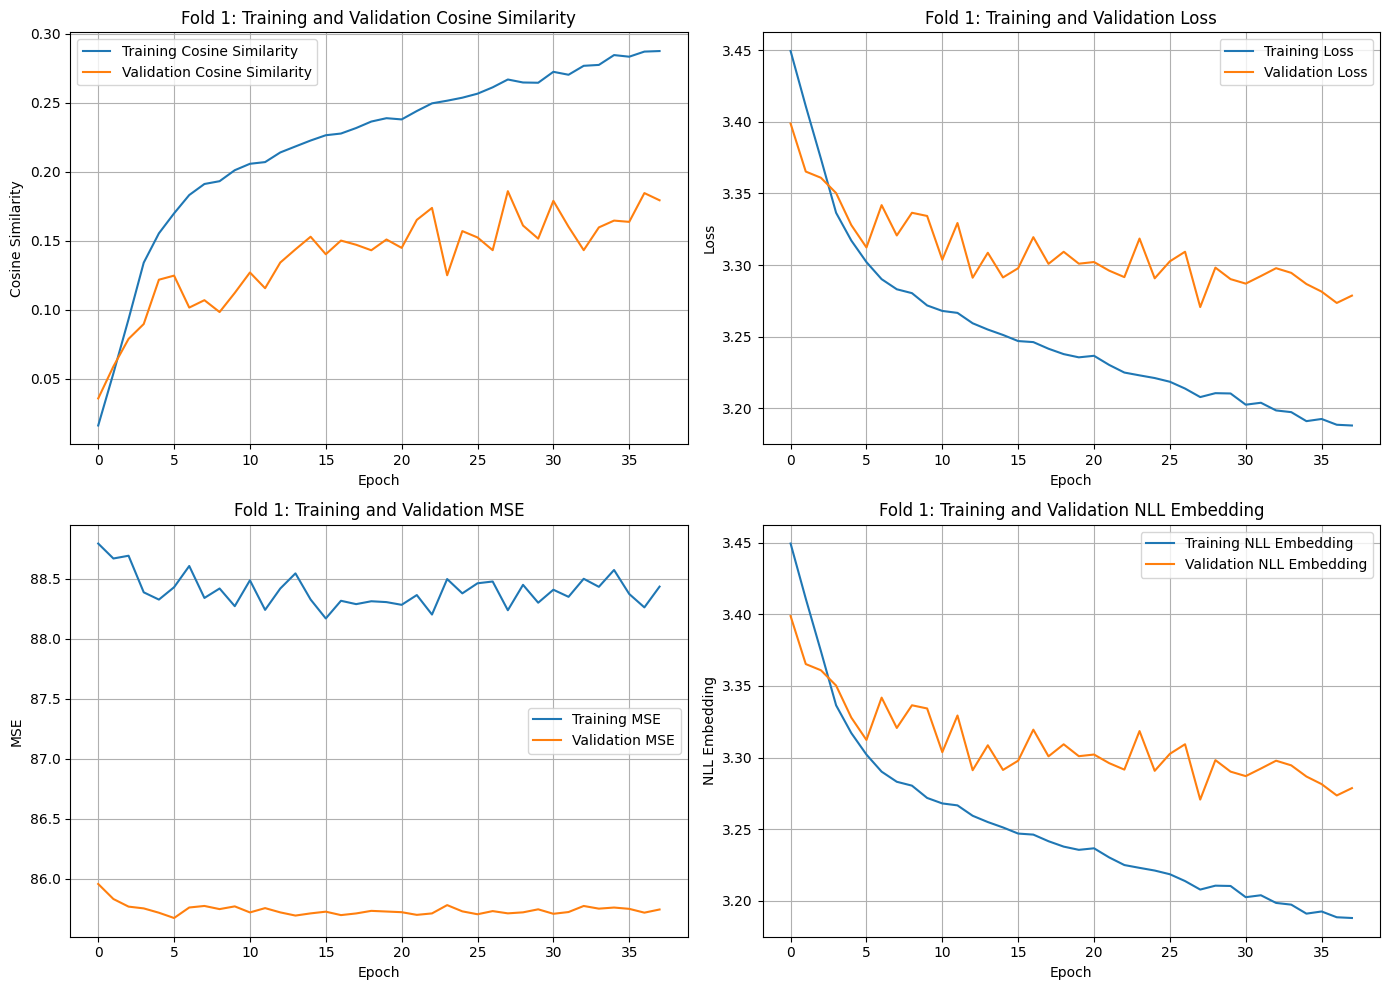

Lag 0, Fold 2:  43%|████▎     | 43/100 [01:13<01:37,  1.71s/it, cosine_sim=0.1864, train_nll_embedding=3.19, train_mse=87.1, train_cosine_sim=0.288, train_loss=3.19, val_nll_embedding=3.3, val_mse=85.7, val_cosine_sim=0.134, val_loss=3.3]   
/tmp/ipykernel_3676101/3150520118.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Fraction of examples included in AUC-ROC calculation: 0.1436, (55 / 383)


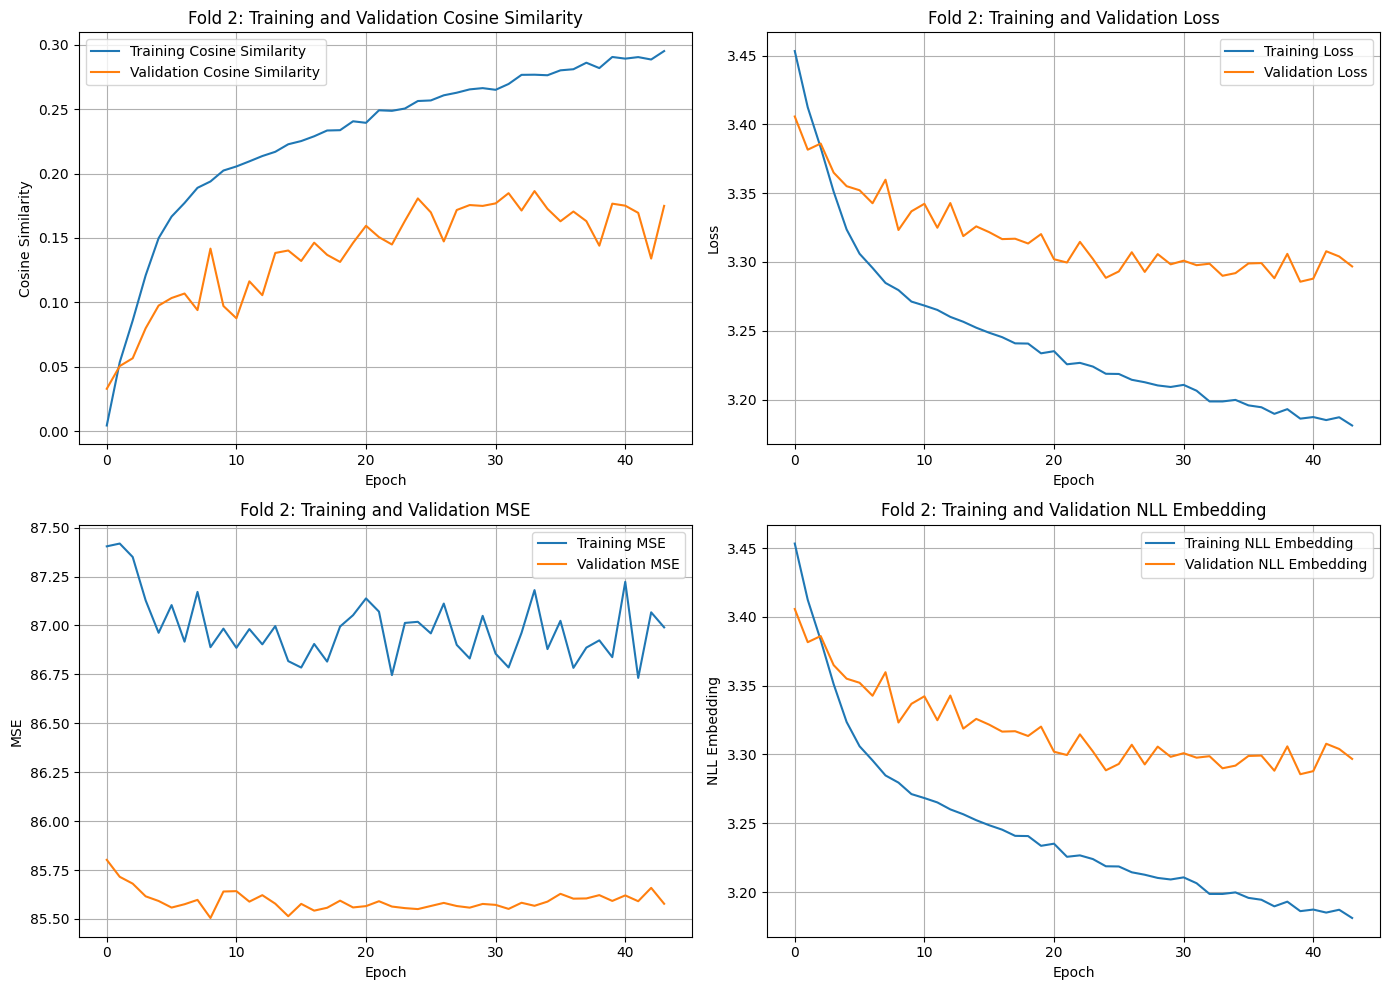

Lag 0, Fold 3:  46%|████▌     | 46/100 [01:19<01:32,  1.72s/it, cosine_sim=0.1892, train_nll_embedding=3.17, train_mse=87.5, train_cosine_sim=0.307, train_loss=3.17, val_nll_embedding=3.3, val_mse=85.6, val_cosine_sim=0.158, val_loss=3.3]    
/tmp/ipykernel_3676101/3150520118.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True`

Fraction of examples included in AUC-ROC calculation: 0.1389, (55 / 396)


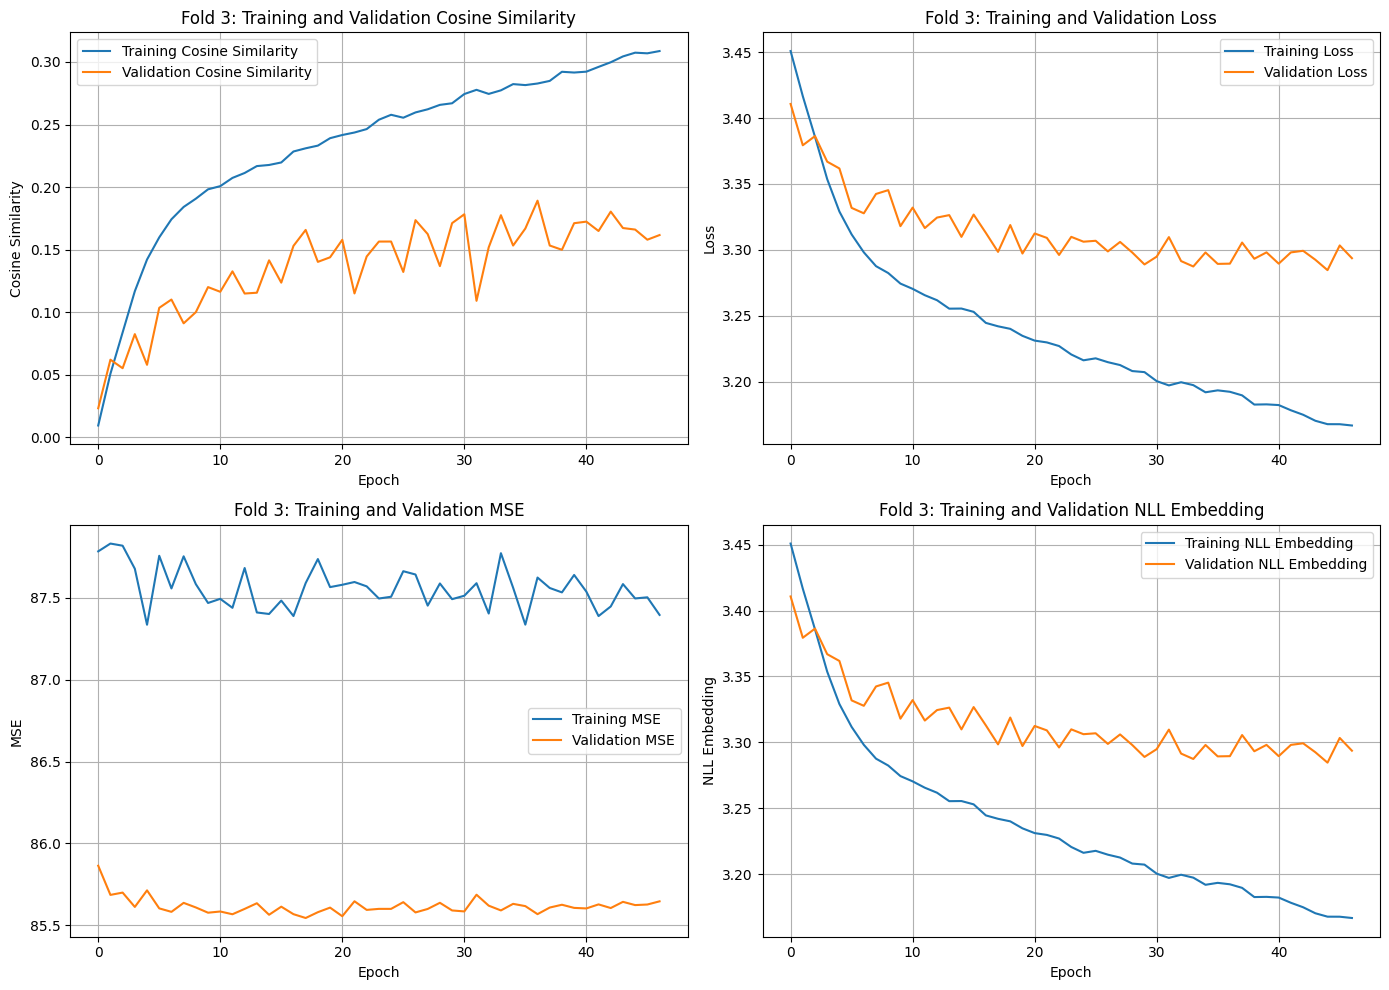

Lag 0, Fold 4:  17%|█▋        | 17/100 [00:30<02:27,  1.78s/it, cosine_sim=0.1500, train_nll_embedding=3.23, train_mse=89.4, train_cosine_sim=0.24, train_loss=3.23, val_nll_embedding=3.32, val_mse=85.6, val_cosine_sim=0.123, val_loss=3.32]  
/tmp/ipykernel_3676101/3150520118.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Fraction of examples included in AUC-ROC calculation: 0.1310, (55 / 420)


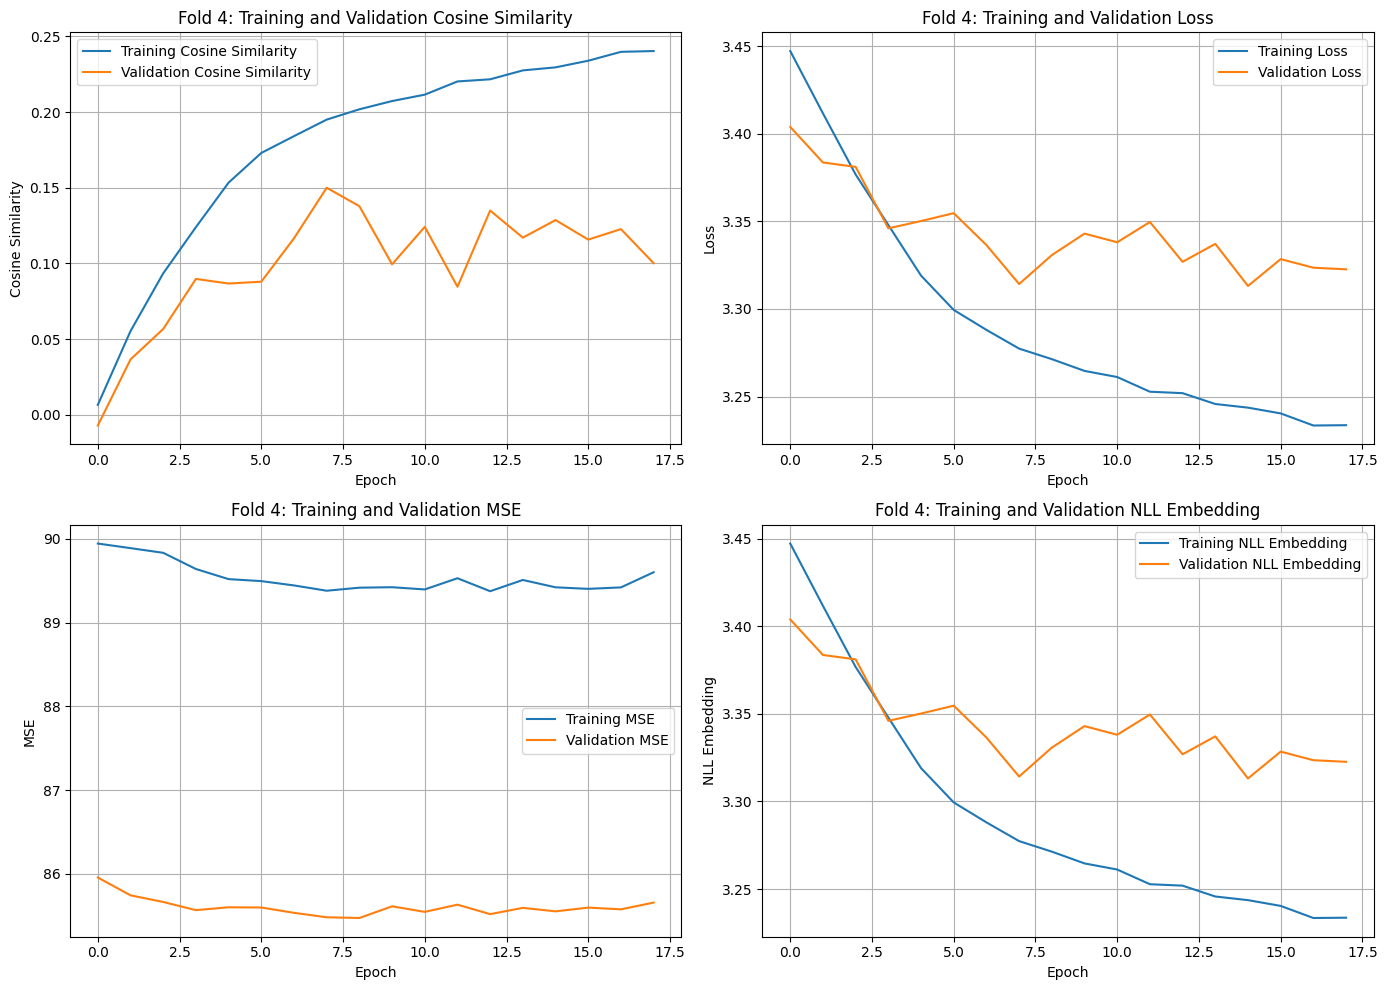

Lag 0, Fold 5:  30%|███       | 30/100 [00:52<02:01,  1.74s/it, cosine_sim=0.1451, train_nll_embedding=3.2, train_mse=89.6, train_cosine_sim=0.278, train_loss=3.2, val_nll_embedding=3.32, val_mse=83.3, val_cosine_sim=0.116, val_loss=3.32]   
/tmp/ipykernel_3676101/3150520118.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

Fraction of examples included in AUC-ROC calculation: 0.1523, (60 / 394)


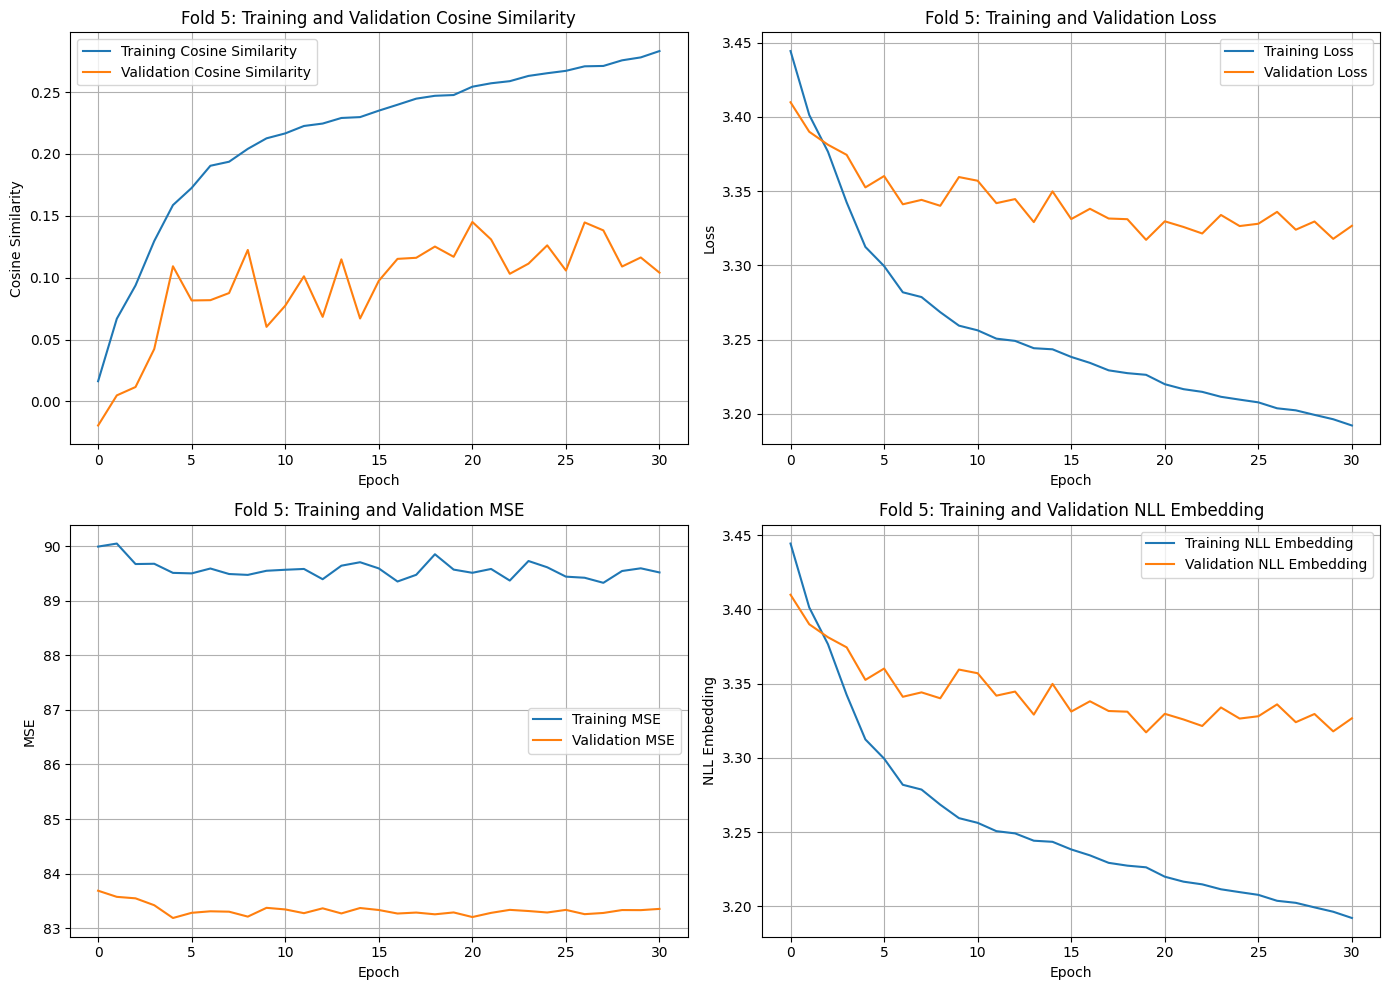


CROSS-VALIDATION RESULTS
Mean train nll_embedding: 3.2192 ± 0.0305
Mean train mse: 88.3867 ± 0.9286
Mean train cosine_sim: 0.2551 ± 0.0316
Mean val nll_embedding: 3.2988 ± 0.0207
Mean val mse: 85.1069 ± 0.9535
Mean val cosine_sim: 0.1713 ± 0.0195
Mean test nll_embedding: 3.2958 ± 0.0152
Mean test mse: 87.4440 ± 2.8793
Mean test cosine_sim: 0.1542 ± 0.0289
Mean test_word_avg_auc_roc: 0.6865 ± 0.0118
Mean test_word_train_weighted_auc_roc: 0.6572 ± 0.0145
Mean test_word_test_weighted_auc_roc: 0.6574 ± 0.0170
Mean test_word_perplexity: 388.4396 ± 12.2173
Mean test_occurrence_perplexity: 994.4811 ± 2.5595
Mean test_word_top_1: 0.0078 ± 0.0031
Mean test_occurrence_top_1: 0.0062 ± 0.0016
Mean test_word_top_5: 0.0364 ± 0.0096
Mean test_occurrence_top_5: 0.0310 ± 0.0063
Mean test_word_top_10: 0.0720 ± 0.0140
Mean test_occurrence_top_10: 0.0510 ± 0.0102


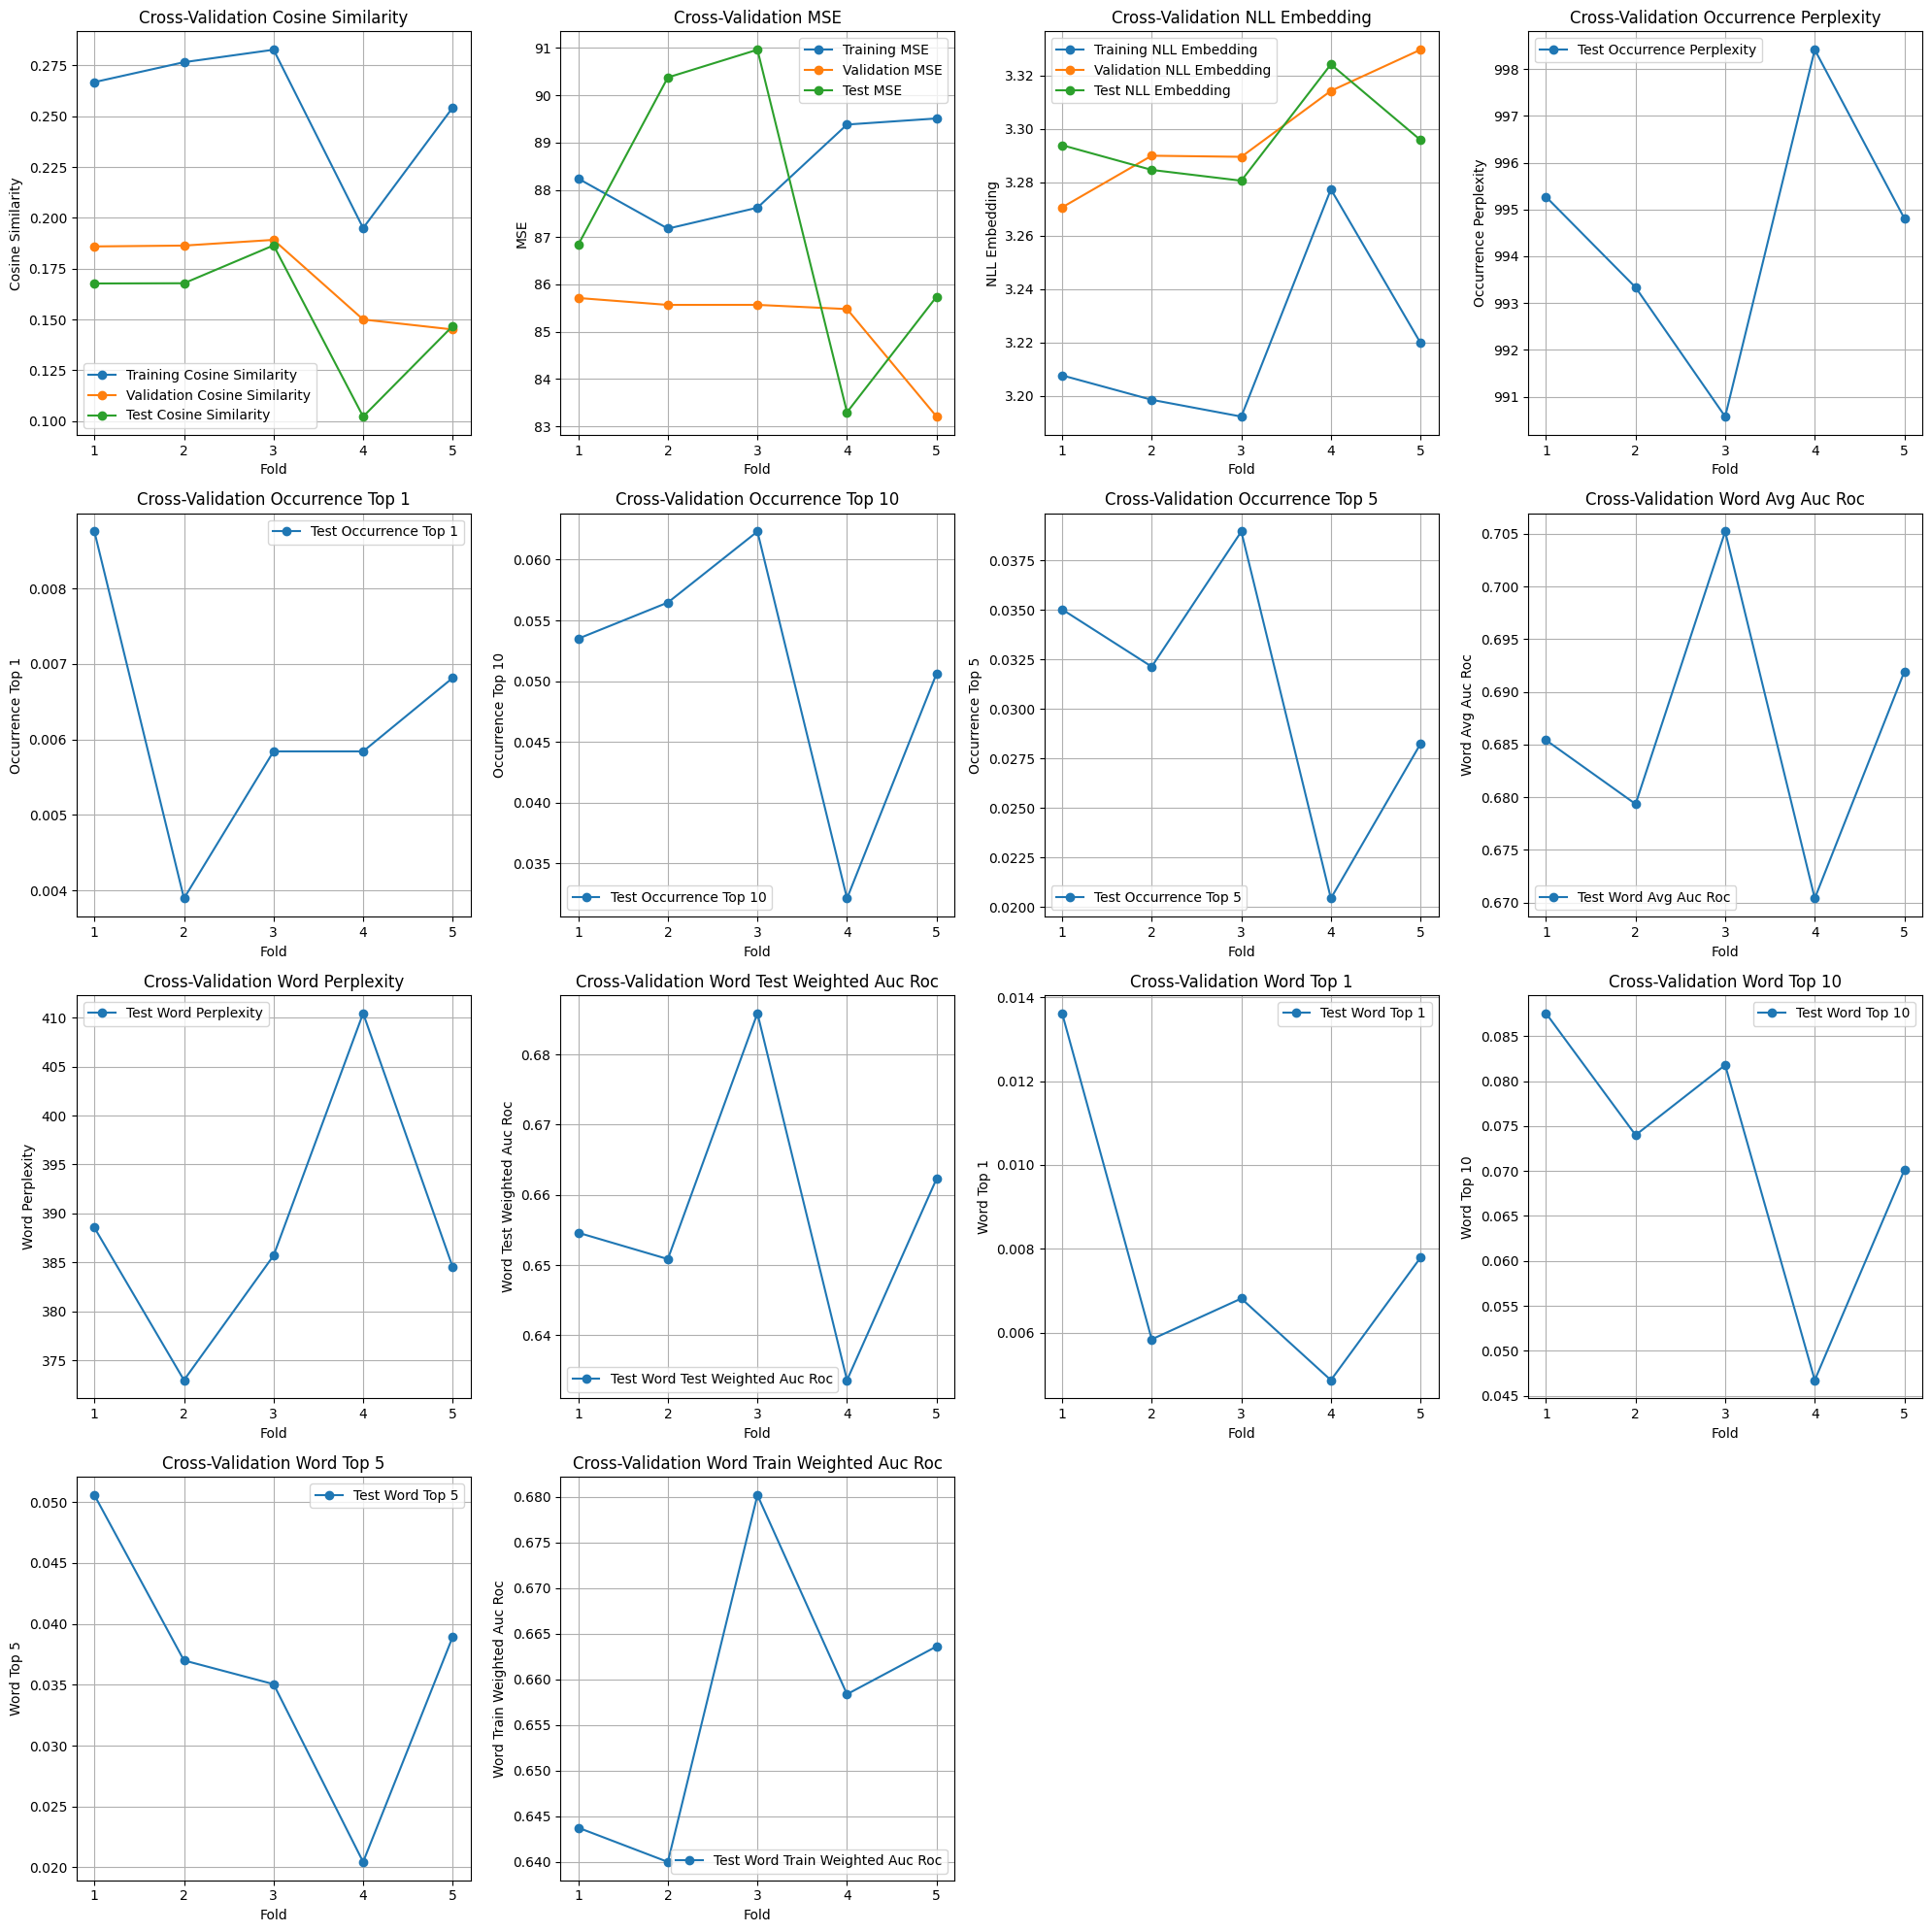

In [10]:
# 1. Prepare device & output dir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(model_dir, exist_ok=True)

# 2. Convert to tensors if needed
if isinstance(X, np.ndarray):
    X = torch.tensor(X, dtype=torch.float32)
if isinstance(Y, np.ndarray):
    Y = torch.tensor(Y, dtype=torch.float32)

# 3. Get fold indices
if fold_type == "sequential_folds":
    fold_indices = get_sequential_folds(X, num_folds=n_folds)
elif fold_type == "zero_shot_folds":
    fold_indices = get_zero_shot_folds(
        selected_words, num_folds=n_folds
    )
else:
    raise ValueError(f"Unknown fold_type: {fold_type}")

# 4. Build a single dict of all metric functions (including loss)
all_fns = setup_metrics_and_loss()
metric_names = all_fns.keys()

# 5. Initialize CV containers
phases = ("train", "val", "test")
cv_results = {f"{phase}_{name}": [] for phase in phases for name in metric_names}
cv_results["num_epochs"] = []

# Hardcode embedding task metrics for now since they need to be handled a bit differently.
# Clean this up later. Hardcoding for now since generalizing this like other metrics would
# get complicated.
# Test type is split between "word" and "occurrence" where word is averaged over
# each time a word occurs and occurence is per-each occurence of the word so is
# more difficult and depends on contextual embeddings.
embedding_metrics = [
    "test_word_avg_auc_roc",
    "test_word_train_weighted_auc_roc",
    "test_word_test_weighted_auc_roc",
    "test_word_perplexity",
    "test_occurrence_perplexity",
]

# Top-K metrics.
for k_val in top_k_thresholds:
    for test_type in ["word", "occurrence"]:
        embedding_metrics.append(f"test_{test_type}_top_{k_val}")

for metric in embedding_metrics:
    cv_results[metric] = []

models, histories = [], []

# 6. Cross‐val loop
for fold, (tr_idx, va_idx, te_idx) in enumerate(fold_indices, start=1):
    model_path = os.path.join(model_dir, f"best_model_fold{fold}.pt")

    # DataLoaders
    datasets = {
        "train": TensorDataset(X[tr_idx], Y[tr_idx]),
        "val": TensorDataset(X[va_idx], Y[va_idx]),
        "test": TensorDataset(X[te_idx], Y[te_idx]),}
    loaders = {
        phase: DataLoader(
            ds, batch_size=batch_size, shuffle=(phase == "train")
        )
        for phase, ds in datasets.items()}

    # Model, optimizer, early‐stop setup
    model = get_model().to(device)
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,)

    best_val, patience = setup_early_stopping_state()
    best_epoch = 0

    # per‐fold history (only train & val, for plotting)
    history = {
        f"{phase}_{name}": [] for phase in ("train", "val") for name in metric_names}
    history["train_loss"] = []
    history["val_loss"] = []
    history["num_epochs"] = None

    loop = tqdm(range(epochs), desc=f"Lag {lag}, Fold {fold}")
    for epoch in loop:
        train_mets = run_epoch(model, loaders["train"], optimizer)
        val_mets = run_epoch(model, loaders["val"])

        # record + TensorBoard
        for name, val in train_mets.items():
            history[f"train_{name}"].append(val)
        for name, val in val_mets.items():
            history[f"val_{name}"].append(val)

        # early stopping on requested metric
        cur = val_mets[early_stopping_metric]
        if should_update_best(cur, best_val, smaller_is_better):
            best_val = cur
            best_epoch = epoch
            torch.save(model.state_dict(), model_path)
            patience = 0
        else:
            patience += 1
            if patience >= early_stopping_patience:
                break

        loop.set_postfix(
            {
                early_stopping_metric: f"{best_val:.4f}",
                **{f"train_{name}": val for name, val in train_mets.items()},
                **{f"val_{name}": val for name, val in val_mets.items()},})

    history["num_epochs"] = best_epoch + 1

    # load best and eval on test set
    model.load_state_dict(torch.load(model_path))
    test_mets = run_epoch(model, loaders["test"])

    # record into cv_results
    for name in metric_names:
        cv_results[f"train_{name}"].append(history[f"train_{name}"][best_epoch])
        cv_results[f"val_{name}"].append(history[f"val_{name}"][best_epoch])
        cv_results[f"test_{name}"].append(test_mets[name])
    cv_results["num_epochs"].append(history["num_epochs"])

    # word‐level ROC and top-k. Only useful for word embedding task.
    # Hardcoded for now since this would be a bit complicated
    # to generalize at the moment.
    results = compute_word_embedding_task_metrics(
        X[te_idx],
        Y[te_idx],
        model,
        device,
        selected_words,
        te_idx,
        tr_idx,
        top_k_thresholds,
        min_train_freq_auc,
        min_test_freq_auc,
        **evaluation_model_params,
    )
    for key, val in results.items():
        cv_results[key].append(val)

    models.append(model)
    histories.append(history)

    if plot_results:
        plot_training_history(history, fold=fold)

# 7. Print CV summary
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
for phase in phases:
    for name in metric_names:
        vals = cv_results[f"{phase}_{name}"]
        print(f"Mean {phase} {name}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")
for metric_name in embedding_metrics:
    vals = cv_results[metric_name]
    print(f"Mean {metric_name}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

if plot_results:
    plot_cv_results(cv_results)

# Key outputs: models, histories, cv_results